In [1]:
%%HTML
<link rel="stylesheet" href="custom.css">

## <span style="color:blue"> Before you start, if you run on colab </span>...
On colab, each notebook runs on its own environment, so you first need to run the following cell in order to upload the required notebooks.

**Advice:** If not done yet, don't forget to change the Runtime type into "GPU" so to speed up the computations.

## <span style="color:blue"> Before you start, if you run on kaggle </span>...
You first need to **turn internet on** (available in the Settings in the right panel). To do that you need to have a verified kaggle account.
On kaggle, each notebook runs on its own environment, so you first need to run the following cell in order to upload the required notebooks.




In [2]:
# First run configuration for colab & kaggle
import sys, os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') != ''

if IN_COLAB or IN_KAGGLE:
    print('Colab detected' if IN_COLAB else 'Kaggle detected')
    if os.path.isdir('2022-mooc-ecmwf-bocquet-brajard'):
      %cd 2022-mooc-ecmwf-bocquet-brajard/
    if not os.path.isfile('mooc_ecmwf_bocquet_brajard_part1.ipynb'):
      !git clone https://github.com/marcbocquet/2022-mooc-ecmwf-bocquet-brajard.git
      %cd 2022-mooc-ecmwf-bocquet-brajard/

Colab detected
Cloning into '2022-mooc-ecmwf-bocquet-brajard'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 307 (delta 65), reused 79 (delta 42), pack-reused 192
Receiving objects: 100% (307/307), 31.29 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/2022-mooc-ecmwf-bocquet-brajard


# <span style="color:maroon"> Data assimilation, machine learning and dynamical systems - Part I  </span>
#### Marc Bocquet¹ [marc.bocquet@enpc.fr](mailto:marc.bocquet@enpc.fr) and Julien Brajard² [julien.brajard@nersc.no](mailto:julien.brajard@nersc.no)
#### (1) CEREA, École des Ponts et EdF R&D, Île-de-France, France
#### (2) Nansen Center (NERSC), Bergen, Norway

During this session, we will discover some connections between data assimilation and deep learning when applied to dynamical systems.

# <span style="color:teal"> First step: consistent model trajectory through data assimilation </span>

## <span style="color:blue"> I. The Lorenz 1996 model </span>

The Lorenz 1996 (L96, [Lorenz and Emanuel 1998]) is a low-order chaotic model commonly used in data assimilation to asse the performance of new algorithms. It represents the evolution of some dynamical meteorological scalar variable over a latitude circular band.

The model **dynamics** is driven by the following set of ordinary differential equations:
$$
    \forall n \in [1, N_{\mathsf{x}}], \quad \frac{\mathrm{d}x_{n}}{\mathrm{d}t} =
    (x_{n+1}-x_{n-2})x_{n-1}-x_{n}+F,
$$
where the indices are periodic: $x_{-1}=x_{N_{\mathsf{x}}-1}$, $x_{0}=x_{N_{\mathsf{x}}}$, and $x_{1}=x_{N_{\mathsf{x}}+1}$, and where the system size $N_{\mathsf{x}}$ can take arbitrary values.

In the standard configuration, $N_{\mathsf{x}}=40$ and the forcing coefficient is $F=8$. The ODEs are integrated using a fourth-order Runge-Kutta scheme with a time step of $0.05$ model time unit (MTU). The resulting dynamics are **chaotic** with a doubling time of errors around $0.42$ MTU. For comparison, $0.05$ MTU represents six hours of real time and corresponds to an average autocorrelation of about $0.967$.

## <span style="color:blue"> II. Physical model integration </span>

We now make an integration of the model to visualise a state trajectory (Hovmöller plot) of the L96 model.
We first import standard modules, graphical package and the model which is a numerical implementation of the above ODEs.

In [3]:
# Import standard modules
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
import pathlib
import json

# Set random seed
np.random.seed(314)

# Directory for results
outputdir = pathlib.Path("./Output")
outputdir.mkdir(exist_ok=True)

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

# Import custom L96 model package
from model.lorenz96 import l96

In the following cell, we define the parameter values of L96 which are taken from the original Lorenz and Emmanuel' paper:
- the number of variables $N_{\mathsf{x}}$ is set to $N_{\mathsf{x}} =40$;
- the forcing coefficient $F$ is set to $F=8$;
- the integration time step is set to $dt=0.05$.

In this configuration, the model variability (spatial average of the time standard deviation per variable) is $3.73$, the doubling time is $0.42$ MTU and the Lyapunov time is $0.61$ MTU. These values might be used later to normalise our plots.

In [4]:
# Set the parameters of L96 and build the model
Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)
phi_stat = dict( model_mean = 2.22,
                 model_std = 3.73,
                 doubling_time = 0.42,
                 lyap_time = 0.61
               )

We now define the length of the various time window which will required in the entire MOOC module as the number of integration timesteps $dt$. This includes the length of a window for a readable Hovmöller plot, the spinup time before carrying out data assimilation, the length of the training and validation window, the length of the test window, and the forecast lead time of the test forecasts:

In [5]:
Nt = dict(
    plot = 500,
    spinup = 1000,
    train = 5000,
    buffer = 5000,
    test = 2000,
    forecast = 400,
)
Nt['total'] = Nt['train']+Nt['buffer']+Nt['test']

# Save them on disk
with open('./Nt.cfg', 'w') as f:
     f.write(json.dumps(Nt))

In the following cell, we perform a rather short model integration, in order to illustrate the model dynamics. The initial condition is a random field.

In [6]:
# Perform a short model integration (for plotting)
xt_plot = np.zeros((Nt['plot'], Nx))
x = 3 + np.random.randn(Nx)
for t in trange(Nt['plot'], desc='physical model integration'):
    x += phi(x)
    xt_plot[t] = x
xt_init = x.copy()

physical model integration:   0%|          | 0/500 [00:00<?, ?it/s]

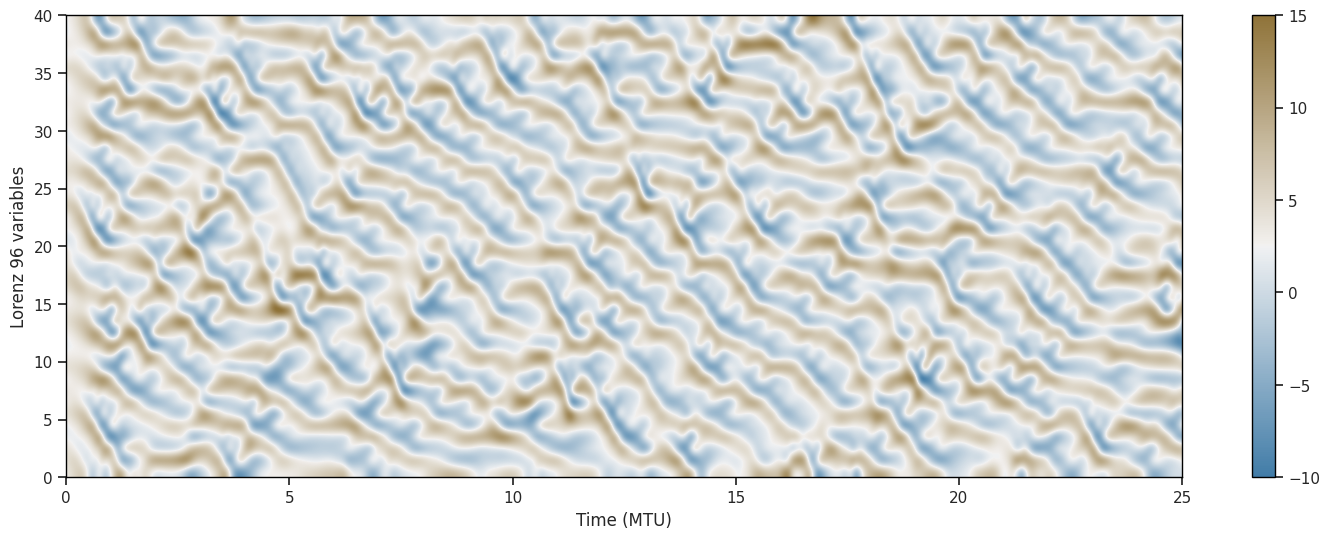

In [7]:
# Plot model integration
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xt_plot.T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*xt_plot.shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

## <span style="color:blue"> III. True model definition </span>

Here, we define the **true model**, which can only be sparsely and noisily observed.
We have devised a non-trivial model for this module whose approximation could be the **physical model**, i.e. the L96 model. We wanted to avoid employing a true model where only a few parameters of L96 are changed, since this can be very easily learned by traditional data assimilation.

These true model dynamics are driven by the following set of ordinary differential equations (ODEs):
$$
    \forall n \in [1, N_{\mathsf{x}}], \quad \frac{\mathrm{d}x_{n}}{\mathrm{d}t} =
    (x_{n+1}-x_{n-2})x_{n-1} + \nu \left\{ x_{n+1}x_{n-1}(x_{n+2}-x_{n-2}) - x_{n+2}x_n(x_{n+3}-x_{n-1})\right\}
    - \lambda x_{n} +  F,
$$
where the indices are periodic: $x_{-1}=x_{N_{\mathsf{x}}-1}$, $x_{0}=x_{N_{\mathsf{x}}}$, and $x_{1}=x_{N_{\mathsf{x}}+1}$, and where the system size $N_{\mathsf{x}}=40$. They can clearly be seem as an extension of the L96 model.

More precisely, for this true model:
- the forcing coefficient is chosen to be $F=8.5$ as opposed to $8$ in L96;
- the friction coefficient is $\lambda=1.01$ as opposed to $1$ in L96;
- more interestingly, we add a cubic term compared to L96 in the tendencies, controlled by the $\nu$ parameter. This term (i) is second-order as in the sense that it is asymptotically consistent with a term of the form $x (\partial x)^2$ (ii) and it conserves the energy $\sum_{n=1}^{N_\mathsf{x}} x_n^2$. Depending on the sign of $\nu$, it could soften or stiffen the L96 model. We choose $\nu=0.025$.

Like for the L96 model, these ODEs are integrated using a fourth-order Runge-Kutta scheme with a time step of $0.05$ model time unit (MTU). The resulting dynamics is **chaotic** with a doubling time of errors around $0.57$ MTU.

In [8]:
# import custom avection model package
from model.lorenz96_cubic import l96cb

# Define the true model as a cubic variant of the L96 model
Nx = 40
dt = 0.05
F = 8.5
diffusion = 0.025 #parameter nu
friction = 1.01 #parameter lambda
tmodel = l96cb(Nx, dt, F, diffusion, friction)

# perform a short model integration (for plotting)
xt_plot = np.zeros((Nt['plot'], Nx))
x = xt_init.copy()
for t in trange(Nt['plot'], desc='true model integration'):
    x += tmodel(x)
    xt_plot[t] = x

true model integration:   0%|          | 0/500 [00:00<?, ?it/s]

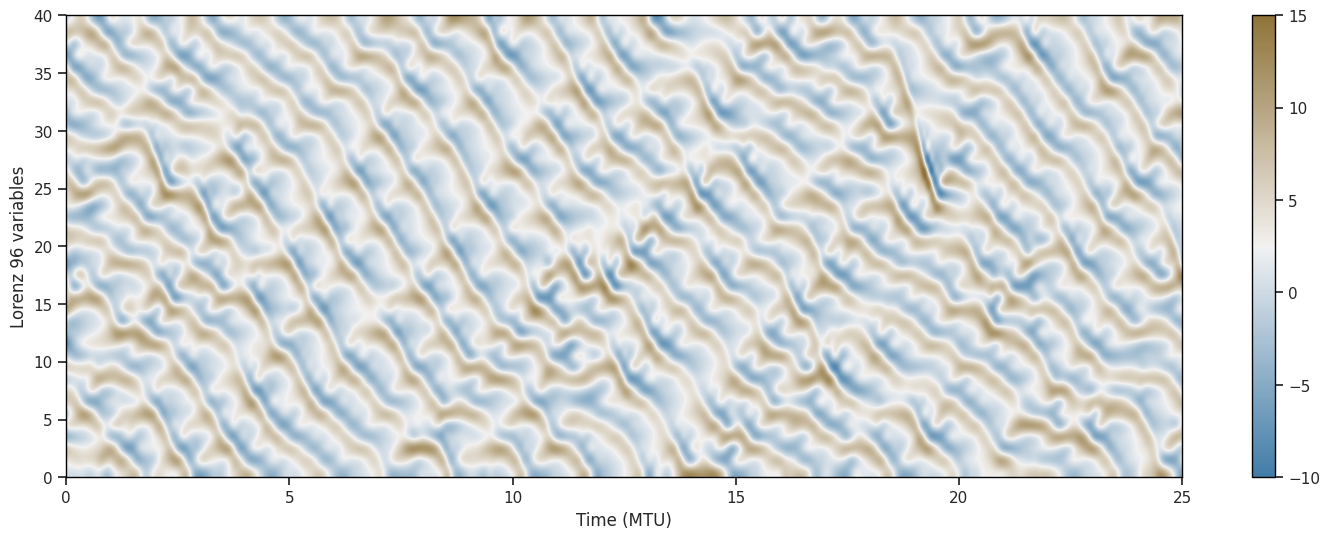

In [9]:
# plot model integration
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xt_plot.T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*xt_plot.shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

For those of you interested in the long-term dynamical properties of this model compared to the L96, we can compute and plot the Lyapunov spectra of both models on the same figure for comparison. We observe from both their Hovmöller plot and from their Lyapunov spectrum that indeed the true model with the chosen parameter values is a less unstable and smoother than the original L96 model (our physical model).

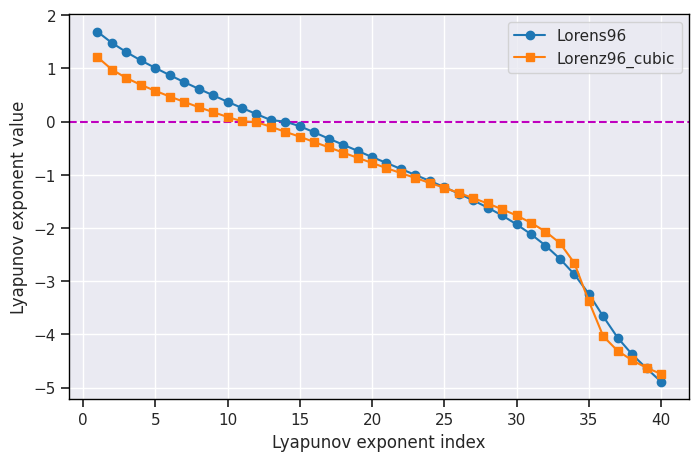

In [10]:
from lyapunov_spectrum.lyaspec import load
index, l96_lyaspec = load('l96_lyaspec.dat')
index, l96cb_lyaspec = load('l96cb_lyaspec.dat')
fig = plt.figure(figsize=(8, 5))
plt.axhline(y=0, color='m', linestyle='dashed')
plt.plot(index, l96_lyaspec, marker="o", label='Lorens96')
plt.plot(index, l96cb_lyaspec, marker="s", label='Lorenz96_cubic')
plt.legend()
plt.xlabel('Lyapunov exponent index')
plt.ylabel('Lyapunov exponent value')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

Some statistics of this model can be computed, for comparison to the L96 model and if normalisation is required later on:

In [11]:
truth_stat = dict( model_mean = 2.12,
                   model_std = 3.54,
                   doubling_time = 0.57,
                   lyap_time = 0.82
                  )

## <span style="color:blue"> IV. Database of observations </span>

Let us first compute a long trajectory of the truth which will be key to our synthetic experiment.
It is locally saved on disk but it will only be accessible through observation for model error discovery.

In [12]:
# Compute the truth trajectory
xt = np.zeros((Nt['total'], Nx), dtype=np.float32)
dates = np.array(range(Nt['total']), dtype=int)
x = xt_init.copy()
for t in trange(Nt['total'], desc='true model integration'):
    x += tmodel(x)
    xt[t] = x
with open(outputdir/'xt.npy', 'wb') as file:
    np.save(file, xt)
with open(outputdir/'dates.npy', 'wb') as file:
    np.save(file, dates)

true model integration:   0%|          | 0/12000 [00:00<?, ?it/s]

In the data assimilation run, only observations of this trajectory will be generated.
To match more realistic conditions, we only observe one every two grid points, and these scalar observations are noisy. Moreover, from one observation time to the next, these grid points are shifted by one grid cell.
Hence, the observation mask in space and time follows a checkerboard pattern. 
For the sake of simplicity, $N_\mathsf{x}$ is assumed even in the following so that one have the same number of observation at each date, i.e. $N_\mathsf{y}=N_\mathsf{x}/2$.

We add a normal i.i.d observation perturbation to each scalar observation, so that
$\mathbf{R}_k = \sigma_\mathrm{obs}^2 \mathbf{I}_{N_\mathsf{x}}$, with $\sigma_\mathrm{obs}=0.2$.

Let us now compute and save on disk this observational database extracted from the trajectory of the true model.

In [13]:
# Build the observation operator
from data_assimilation.observation import checkerboard
H = checkerboard(Nx)

# Compute the observation database
Ny = H.Ny[0]
sig_obs = 0.1    # previously 0.2
yp = np.empty((Nt['train'], Ny), dtype=np.float32)
for t in trange(Nt['train'], desc='generating observations'):
    yp[t] = H(xt[t], t) + np.random.normal(0, sig_obs, Ny)
with open(outputdir/'yp.npy', 'wb') as file:
    np.save(file, yp)

generating observations:   0%|          | 0/5000 [00:00<?, ?it/s]

At this point, we have at our disposal, a noisy and sparse observational database of the truth $\mathbf{y}_\mathsf{p}$ on the one hand, and the physical model $\Phi$, an approximation of the true model, on the other hand. The goal is to learn a correction to $\Phi$ to get closer to the dynamics of the true model. To do so, we want to apply the very first step of our combined DA+ML algorithm.

The first step is to apply data assimilation with the goal to reconstruct a full field of the system.
The second step, in part II of this module, will apply machine learning to this reconstructed full field.

## <span style="color:blue"> IV. Data assimilation with an ensemble Kalman filter </span>

The data assimilation method that we choose is a deterministic EnKF, the ensemble transform Kalman filter (ETKF, [Hunt et al 2007]) to the problem, with an ensemble choosen to be $N_\mathrm{e}=40$ to avoid the need for localisation, only for the sake of simplicity (see [Malartic et al. 2022] for generalisations with localisation).

A gentle introduction to the ETKF at a master level can be found in chapter 5 of http://cerea.enpc.fr/HomePages/bocquet/teaching/assim-mb-en.pdf.

We assume that we know the observation error statistics, in particular $\sigma_\mathrm{obs}=0.2$.

In addition, we incorporate in the scheme a way to account for model error, i.e. the fact that $\Phi$ is an approximation of the true dynamics. In the absence of such scheme, the EnKF would diverge, being overconfident in its estimation of the errors.

This is achieved by
- the SQRT-CORE scheme [Raanes et al, 2015] with the simplest i.i.d. assumption: $\mathbf{Q}_k = \sigma_q^2 \mathrm{I}$; We choose to use $\sigma_q^2=0.3 \, dt$.
- and via a state-of-the-art adaptive inflation scheme [Raanes et al, 2019].

This just tells the EnKF to be cautious about its estimation of uncertainty and apply a margin of error to be on the safer side, and hence avoid divergence of the EnKF.


In [15]:
from data_assimilation.enkf_call import call
Ne = 40                  # Ensemble size
sig_q = np.sqrt(0.3*dt)  # Magnitude for the SQR-CORE correction
sig_x = 0.1       #previously 0.1       # spread of the intial ensemble and std of its mean.
infl = 1                 # mulitplicative inflation

models = (phi, xt, H, yp, dates)
params = (Nx, dt, Nt['train'], Nt['spinup'], Ne, sig_obs, sig_x, sig_q, infl)

print("> run")
xa, rmse_mean, spread_mean, rmsei_mean, zeta_mean, wctime, prtime = call(models, params)
print("> wctime(s)", wctime, " prtime(s)", prtime)
print("> rmse_mean", rmse_mean, "spread_mean", spread_mean, "rmsei_mean", rmsei_mean)
print("> zeta_mean", zeta_mean)

# Save the analysis trajectory
with open(outputdir / 'xa.npy', 'wb') as file:
    np.save(file, xa)

> run
> generate ensemble
> data assimilation run


running EnKF:   0%|          | 0/5000 [00:00<?, ?it/s]

> wctime(s) 41.95043422200001  prtime(s) 65.63974518500001
> rmse_mean 0.14469362242706146 spread_mean 0.14832299851756534 rmsei_mean 2.708539928242783
> zeta_mean 26.399129449381395


Because this is a twin experiment, it is possible to check how close to the true full trajectory is the analysed trajectory. The root mean square error (RMSE) between the analysis and the truth should be about $0.20$, or the same order as the observation error of $0.2$ but as an average over both the gauged and ungauged grid points, and with an approximate physical model.

Within the data assimilation run, there was also an estimation of the error made by a cubic interpolation over the ungauged grid points. The RMSE for all sites as compared to the truth should be about $2.71$, and slightly below $1$ for the observed grid points, as expected. 

$\overline{\zeta} \approx 29$ is a measure of the effective size of the ensemble as diagnosed by our adaptive hybrid EnKF-N scheme.

For good measure, let us plot a slice of the analysis trajectory: 

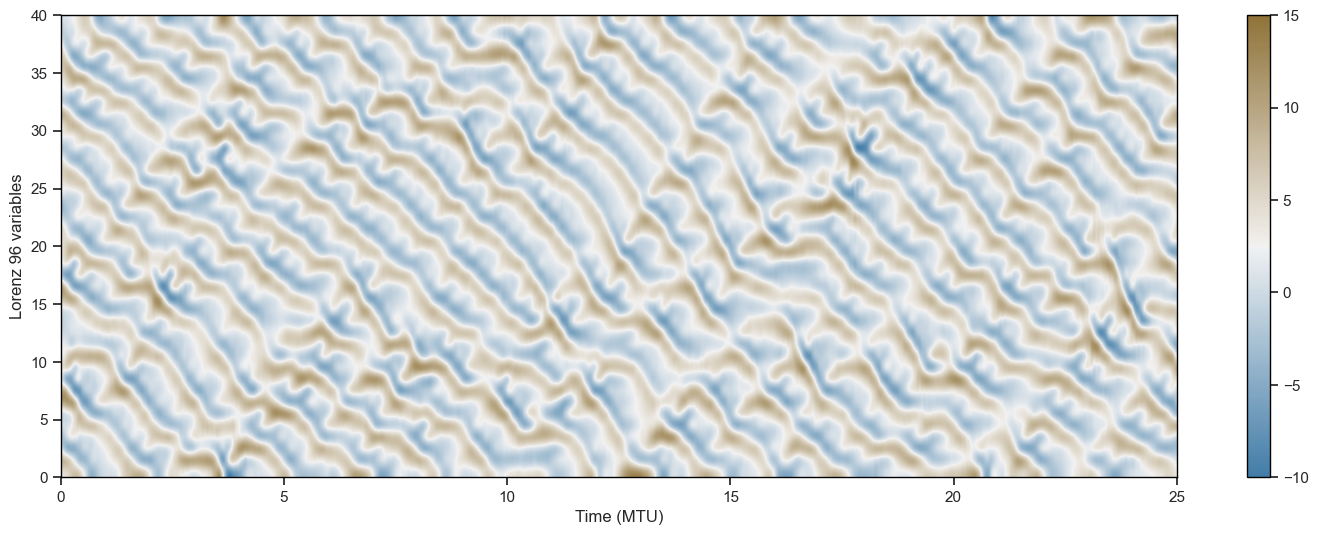

In [ ]:
# plot a slice of the analsyis trajectory
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xa[Nt['plot']:2*Nt['plot']].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*xt_plot.shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

## <span style="color:blue"> V. Provisional conclusion, on our way to part II  </span>

Hence, it is clear that the data assimilation run is worth using. Note that we have not used any smoother data assimilation method, which could have be more complex but also more accurate.

We can now convey the analysis trajectory to the machine learning step, which is part II of our module.
All the necessary fields are stored in "./Ouput".

If you are under Colab or kaggle, click here to continue with part II: 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg) ](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/data_assimilation/mooc_ecmwf_bocquet_brajard_part2.ipynb) 

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/data_assimilation/mooc_ecmwf_bocquet_brajard_part2.ipynb)